# Tensorflow Model

In [1]:
from os import path
from random import sample

import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd


In [61]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

BATCH_SIZE = 256
BUFFER_SIZE = 10000
EVALUATION_INTERVAL = 1000
EPOCHS = 10

### Load, split, and normalize the training data

In [70]:
def load_raw_evalmetrics_df():
    return pd.read_pickle(path.join('.', 'raw_evalmetrics_df.pkl'))

def prep_multivarate(df):
    """ Calculates density and removes unnecessary columns """
    new_df = df.copy()
    new_df['density'] = df.latestTotalPopulation / df.LND110210
    new_df = new_df.drop(columns=['latestTotalPopulation','fips','LND110210'])
    return new_df

def split_sample(df, percent_train=.80):
    county = set(df.county)
    train_county = sample(county, int(len(county) * percent_train))
    val_county = county - set(train_county)
    train_filter = [c in train_county for c in df.county]
    val_filter = [c in val_county for c in df.county]
    return df[train_filter].fillna(0), df[val_filter].fillna(0)

def normalize_df(train_df, val_df):
    new_train_df = train_df.copy()
    new_val_df = val_df.copy()
    cols = ['confirmed_cases','confirmed_deaths', 'confirmed_recoveries','hospitalIcuBeds','hospitalStaffedBeds','hospitalLicensedBeds', 'density']
    for col in cols:
        # calculate mean and std on training data only
        data = new_train_df[col].astype('float')
        data_mean = data.mean(axis=0)
        data_std = data.std(axis=0)
        new_train_df[col] = (data-data_mean)/data_std
        #apply to val data
        data = new_val_df[col].astype('float')
        new_val_df[col] = (data-data_mean)/data_std
    return new_train_df.fillna(0), new_val_df.fillna(0)

def get_data():
    evalmetric_df = load_raw_evalmetrics_df()
    prepped_df = prep_multivarate(evalmetric_df)
    train_df, val_df = split_sample(prepped_df)
    return normalize_df(train_df, val_df)



### Prep the data for RNN

In [71]:
# inspired by https://www.tensorflow.org/tutorials/structured_data/time_series


def multivariate_data(dataset, target_col, history_size=20, target_size=0):
    data = []
    labels = []
    
    counties = set(dataset.county)
    
    for j, county in enumerate(counties):
        if (j + 1) % 100 == 0:
            print('.', end='')
        sub_dataset = dataset[dataset.county == county]
        target = sub_dataset[target_col].values
        sub_dataset = sub_dataset.drop(columns=['county', 'date'])
        sub_dataset = sub_dataset.values
        start_index = history_size
        end_index = len(sub_dataset) - target_size

        for i in range(start_index, end_index):
            indices = range(i-history_size, i)
            data.append(sub_dataset[indices])

            labels.append(target[i+target_size])

    print()
    return np.array(data), np.array(labels)



### Build the Tensorflow model

In [72]:
def slice_cache_for_tensorflow(x_train, y_train, x_val, y_val):
    x_train = np.asarray(x_train).astype(np.float32)
    y_train = np.asarray(y_train).astype(np.float32)
    train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

    x_val = np.asarray(x_val).astype(np.float32)
    y_val = np.asarray(y_val).astype(np.float32)
    val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    val_data = val_data.batch(BATCH_SIZE).repeat()
    
    return train_data, val_data

def build_and_compile_model(x_train):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(32, input_shape=x_train.shape[-2:]))
    model.add(tf.keras.layers.Dense(1))

    model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')
    return model

def fit_model(model, train_data, val_data):
    history = model.fit(train_data, epochs=EPOCHS,
                            steps_per_epoch=EVALUATION_INTERVAL,
                            validation_data=val_data,
                            validation_steps=50)

In [73]:
train_df, val_df = get_data()
x_train, y_train = multivariate_data(train_df, 'confirmed_deaths')
x_val, y_val = multivariate_data(val_df, 'confirmed_deaths')

train_data, val_data = slice_cache_for_tensorflow(x_train, y_train, x_val, y_val)
model = build_and_compile_model(x_train)
history = fit_model(model, train_data, val_data)






.........................
......
Epoch 1/10
1000/1000 [==============================] - 17s 17ms/step - loss: 0.0271 - val_loss: 0.0129
Epoch 2/10
1000/1000 [==============================] - 19s 19ms/step - loss: 0.0300 - val_loss: 0.0051
Epoch 3/10
1000/1000 [==============================] - 22s 22ms/step - loss: 0.0259 - val_loss: 0.0046
Epoch 4/10
1000/1000 [==============================] - 22s 22ms/step - loss: 0.0222 - val_loss: 0.0032
Epoch 5/10
1000/1000 [==============================] - 22s 22ms/step - loss: 0.0241 - val_loss: 0.0034
Epoch 6/10
1000/1000 [==============================] - 23s 23ms/step - loss: 0.0185 - val_loss: 0.0049
Epoch 7/10
1000/1000 [==============================] - 22s 22ms/step - loss: 0.0195 - val_loss: 0.0026
Epoch 8/10
1000/1000 [==============================] - 21s 21ms/step - loss: 0.0242 - val_loss: 0.0054
Epoch 9/10
1000/1000 [==============================] - 19s 19ms/step - loss: 0.0178 - val_loss: 0.0030
Epoch 10/10
1000/1000 [========

### Plots

In [77]:
def create_time_steps(length):
    return list(range(-length, 0))


In [78]:
def show_plot(plot_data, delta, title):
    
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                   label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

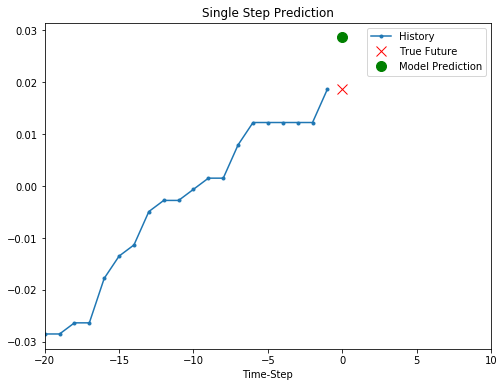

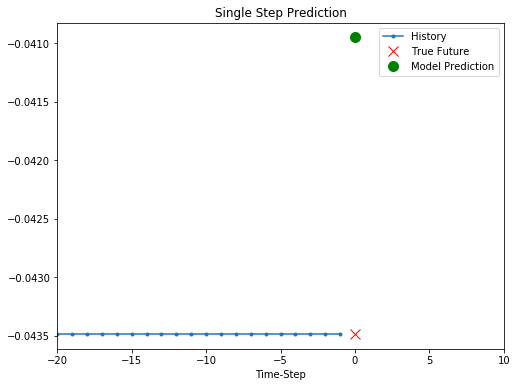

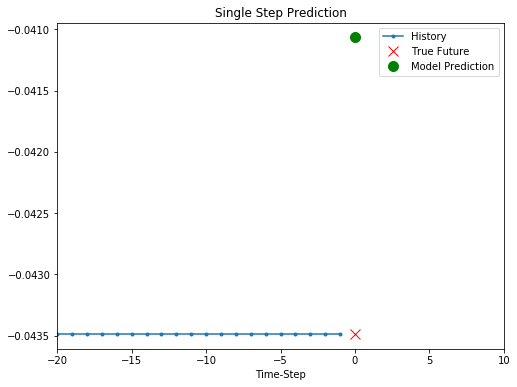

In [90]:
for x, y in val_data.skip(100000).take(3):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    model.predict(x)[0]], 0,
                   'Single Step Prediction')
    plot.show()